# Strategies trading results comparison

In [1]:
%%capture
%pip install plotly==5.9.0
%pip install twisted
%pip install binance-connector==1.13.0
%pip install pandas 

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

## Download trading data
Download the data from cloud, read strategies databases for analysis

In [2]:
plot_figsize=(10,5)
strategies=["SimpleKerasStrategy", "LSTMStrategy", "LSTMStrategy2"]
strategies=["SimpleKerasStrategy"]

In [3]:
import os
from datetime import datetime

os.system("cd ./../deploy/yandex_cloud; ./download_data.sh")
print(f"Download completed at {datetime.utcnow()} UTC.")

receiving incremental file list
LSTMStrategy/LSTMStrategy.db
LSTMStrategy/Xy/2023-06-17_BTCUSDT_X.csv
LSTMStrategy/Xy/2023-06-17_BTCUSDT_data.csv
LSTMStrategy/Xy/2023-06-17_BTCUSDT_y.csv


file has vanished: "/home/yc-user/pytrade2/data/LSTMStrategy/weights/2023-06-17T12:18:40.631007.data-00000-of-00001"
file has vanished: "/home/yc-user/pytrade2/data/LSTMStrategy/weights/2023-06-17T12:18:40.631007.index"


LSTMStrategy/account/2023-06-17_balance.csv
LSTMStrategy/weights/checkpoint
LSTMStrategy2/LSTMStrategy2.db
LSTMStrategy2/Xy/2023-06-17_BTCUSDT_X.csv
LSTMStrategy2/Xy/2023-06-17_BTCUSDT_data.csv
LSTMStrategy2/Xy/2023-06-17_BTCUSDT_y.csv
LSTMStrategy2/account/2023-06-17_balance.csv
LSTMStrategy2/weights/2023-06-17T12:18:39.548076.data-00000-of-00001
LSTMStrategy2/weights/2023-06-17T12:18:39.548076.index
LSTMStrategy2/weights/checkpoint
SimpleKerasStrategy/SimpleKerasStrategy.db
SimpleKerasStrategy/Xy/2023-06-17_BTCUSDT_X.csv
SimpleKerasStrategy/Xy/2023-06-17_BTCUSDT_data.csv
SimpleKerasStrategy/Xy/2023-06-17_BTCUSDT_y.csv
SimpleKerasStrategy/account/2023-06-17_balance.csv
SimpleKerasStrategy/weights/2023-06-17T12:18:54.686615.data-00000-of-00001
SimpleKerasStrategy/weights/2023-06-17T12:18:54.686615.index
SimpleKerasStrategy/weights/checkpoint

sent 280.213 bytes  received 39.232.284 bytes  2.257.856,97 bytes/sec
total size is 320.647.977  speedup is 8,12
LSTMStrategy last opened: , clos

rsync warning: some files vanished before they could be transferred (code 24) at main.c(1865) [generator=3.2.7]


In [4]:
import pandas as pd
import numpy as np
import sqlite3

def get_balance(strategy: str):
    """ Read balance history from data"""
    
    data_dir=f"../data/yandex-cloud"
    account_dir=f"{data_dir}/{strategy}/account"
    #file_path = sorted([f for f in os.listdir(account_dir) if f.endswith(f"{symbol}_{name}.csv")])[-1]
    files = sorted([f for f in os.listdir(account_dir) if f.endswith(f".csv")])
    return pd.concat([pd.read_csv(f"{account_dir}/{f}", parse_dates=True, index_col="time") for f in files]).sort_index()
    

def get_trades(strategy: str):
    """ Read strategy trades from related sqlite3 database"""
    data_dir=f"../data/yandex-cloud"
    fee=0.0012

    db_path=f"{data_dir}/{strategy}/{strategy}.db"
    print(f"Get {strategy} trades from {db_path}")

    with sqlite3.connect(db_path) as conn:
        trades=pd.read_sql_query("SELECT * FROM trade ORDER BY open_time",conn,
                                 parse_dates=["open_time", "close_time"])#.set_index("open_time", drop=False)
    trades["profit"] = np.where(trades["side"] == "BUY", 
                                (trades["close_price"]-trades["open_price"])*trades["quantity"],
                                (trades["open_price"]-trades["close_price"])*trades["quantity"],
                               )
    trades["profit"] = trades["profit"] - fee*(trades["open_price"] + trades["close_price"])*trades["quantity"]
    trades["cum_profit"] = trades["profit"].cumsum()
    open_time=trades["open_time"].iloc[-1]    
    close_time=trades["close_time"].iloc[-1]    
    print(f"{strategy} last trade open: {open_time}, close: {close_time}\n")  
    
    return trades

# Main data structure: strategy -> trades dictionary
strategies_trades = dict([(strategy, get_trades(strategy)) for strategy in strategies])
strategies_balances = dict([(strategy, get_balance(strategy)) for strategy in strategies])



Get SimpleKerasStrategy trades from ../data/yandex-cloud/SimpleKerasStrategy/SimpleKerasStrategy.db
SimpleKerasStrategy last trade open: 2023-06-17 12:15:52.280000, close: NaT



In [5]:
trades=strategies_trades.get("SimpleKerasStrategy")
#trades.dropna().tail()
trades.tail()
#trades[trades["close_order_id"].isnotnone()].tail()
#sb=strategies_balances["SimpleKerasStrategy"]    
#sb.tail(100)

,id,ticker,side,open_time,open_price,open_order_id,stop_loss_price,take_profit_price,stop_loss_order_id,trailing_delta,quantity,close_time,close_price,close_order_id,status,profit,cum_profit
123,124,btcusdt,BUY,2023-06-17 05:47:13.885,26675.99,828936253705066,26637.22,26804.23,828936253769087,None,0.0005,2023-06-17 07:02:12.187,26635.48,None,closed,-0.052242,-4.983323
124,125,btcusdt,BUY,2023-06-17 11:30:04.843,26556.00,828939089380027,26542.72,26613.91,828939080664680,None,0.0005,2023-06-17 11:37:11.716,26541.76,None,closed,-0.038979,-5.022301
125,126,btcusdt,SELL,2023-06-17 11:46:38.186,26534.98,828939248207968,26548.25,26474.63,828939274228876,None,0.0005,2023-06-17 11:50:48.526,26550.00,None,closed,-0.039361,-5.061662
126,127,btcusdt,SELL,2023-06-17 12:10:47.183,26504.99,828939492033062,26534.95,26448.30,828939492066169,None,0.0005,2023-06-17 12:15:26.807,26535.00,None,closed,-0.046829,-5.108491
127,128,btcusdt,SELL,2023-06-17 12:15:52.280,26529.21,828939534178559,26577.63,26437.43,828939517041913,None,0.0005,NaT,NaN,None,opened,NaN,NaN


## Balance history

In [18]:
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.stats as stats
import seaborn as sns
sns.set_theme()


def prepare_balance(df):
    del df["available"]
    df=df[df["balance"].notnull()].dropna()
#    df["balance_diff"]=df["balance"].diff()
    df=df[1:] # Hack for specific df of 2023-06-11
    df=df.reset_index()
    #df["delta"]=df["balance"] - df["balance"].shift(2))/df["balance"] < 0.2]
    #df["balance_diff"] = df["balance"].diff()
    #print(df.balance.diff())
    df=df[df.index%2==1]
    df=df[abs(stats.zscore(df["balance"]))< 1.9]
    #df=df[abs(df["balance"].diff()/df["balance"])< 0.3]
    df["balance_diff"] = df.balance.diff()
    #print(df)
    df=df.set_index("datetime", drop=False)
    return df

def plot_strategies_balances(strategies, asset):
    """ Plot all strategies balance history"""
    
    # Charts for each strategy
    for strategy in strategies:
        strategy_df=strategies_balances[strategy]

        # Chart for each asset
        for asset in strategy_df["asset"].unique():
            asset_df=strategy_df[strategy_df["asset"]==asset].copy()
            asset_df["datetime"]=asset_df.index

            asset_df=prepare_balance(asset_df)
            
            #plt.figure(figsize=plot_figsize)
            asset_df=asset_df[["datetime", "balance", "balance_diff"]].dropna()
            title=f"{strategy} {asset.upper()} balance"
            px.line(asset_df, "datetime", "balance", title=title) .update_traces(mode='lines+markers').show()

#             title=f"{strategy} {asset.upper()} balance diff"
#             px.line(asset_df, "datetime", "balance_diff", title=title) .update_traces(mode='lines+markers').show()

            
#             plt.plot("datetime", "balance", data=asset_df[["datetime", "balance"]].dropna())
#             plt.title(f"{strategy} {asset} balance")
#             plt.show()

        
plot_strategies_balances(strategies_balances, "usdt")



## Cumulative profit

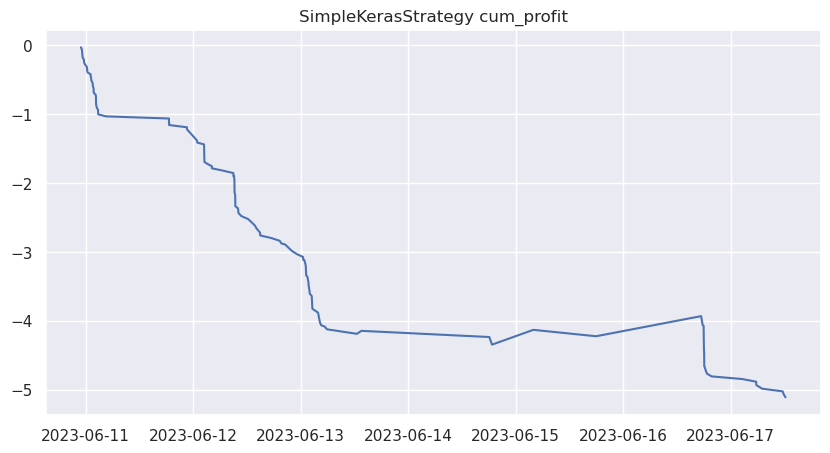

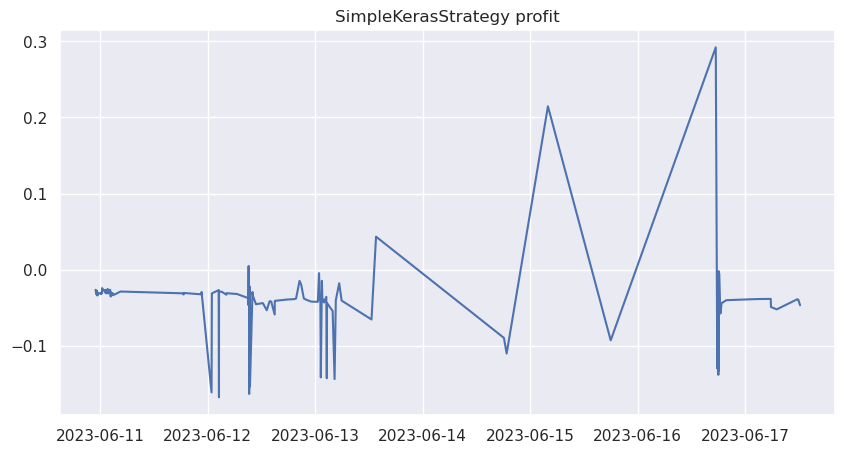

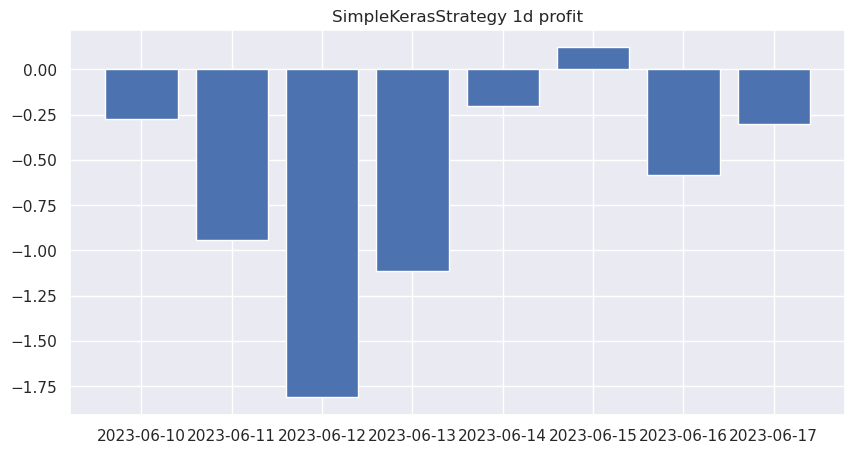

In [7]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_theme()
#paper, notebook, talk, poster

import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots
pio.renderers.default = "plotly_mimetype+notebook"
import plotly.graph_objects as go

# Align the plot width    
plot_figsize=(10,5)
sns.set_style("darkgrid")


def plot_profit_plotly(strategy, trades, col):
    """ Plot strategy profit using plotly"""
    px.line(trades, x="close_time", y=col, title=f"{strategy} {col}").update_traces(mode='lines+markers').show()
    
def plot_profit_sns(strategy, trades, col):
    """ Plot strategy profit using sns"""
    plt.figure(figsize=plot_figsize)
    sns.lineplot(data=trades, x="close_time", y=col).set_title(f"{strategy} {col}")
    plt.show()

def plot_profit_plt(strategy, trades, col):
    """ Plot profits using matplotlib """
    plt.figure(figsize=(10,5))
    plt.plot("close_time", col, data=trades)
    plt.title(f"{strategy} {col}")
    plt.show()
    
def plot_strategies_profits(plot_func, strategies_trades, col):
    """ Plot all strategies profit using given func"""
    
    for strategy in strategies:
        trades=strategies_trades[strategy]
        plot_func(strategy, trades, col)

def plot_strategies_daily_profits(plot_func, strategies_trades, col):
    """ Plot daily values"""
    interval="1d"
    for strategy in strategies:
        trades = strategies_trades[strategy]
        resampled=trades.set_index("close_time")[["profit", "cum_profit"]] \
            .resample(interval) \
            .agg({"profit": "sum", "cum_profit": "last"})\
            .reset_index()
        resampled["close_time"] = resampled["close_time"].astype(str)
        plt.figure(figsize=plot_figsize)
        plt.bar("close_time", col, data=resampled)
        plt.title(f"{strategy} {interval} {col}")
        plt.show()
        
# Plot profit and cumulative profit for each strategy
plot_strategies_profits(plot_profit_plt, strategies_trades, "cum_profit")
plot_strategies_profits(plot_profit_plt, strategies_trades, "profit")
plot_strategies_daily_profits(plot_profit_plt, strategies_trades, "profit")



## Buy, sell trade counts

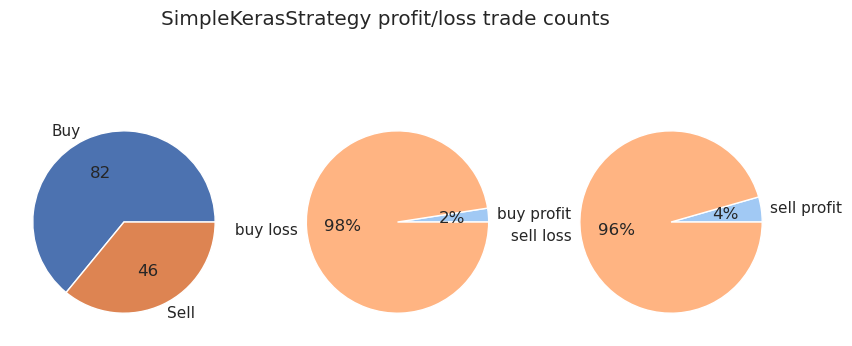

In [8]:
def plot_trade_counts(strategy, trades):
    buy_sell_counts = trades["side"].value_counts()
    total=len(trades)
    colors = sns.color_palette('pastel')[0:5]
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(plot_figsize)
    fig.suptitle(f'{strategy} profit/loss trade counts')
    # Buy/sell counts
    ax1.pie([len(trades[trades["side"]=="BUY"]),len(trades[trades["side"]=="SELL"])], 
            labels=["Buy","Sell"], \
            autopct=lambda p: '{:.0f}'.format(p * total / 100))
    # Buy profit/loss counts
    ax2.pie([len(trades[(trades["side"]=="BUY") &  (trades["profit"]>0)].index),\
            len(trades[(trades["side"]=="BUY") &  (trades["profit"]<0)].index) \
            ],
            labels=["buy profit", " buy loss"], autopct="%.0f%%", colors=colors)
    # Sell profit/loss counts
    ax3.pie([len(trades[(trades["side"]=="SELL") &  (trades["profit"]>0)].index),\
            len(trades[(trades["side"]=="SELL") &  (trades["profit"]<0)].index) \
            ],
            labels=["sell profit", " sell loss"], autopct="%.0f%%", colors=colors)
    fig.subplots_adjust(top=1)

    plt.show()



for strategy in strategies_trades:
    plot_trade_counts(strategy, strategies_trades[strategy])

## Compare strategies profits

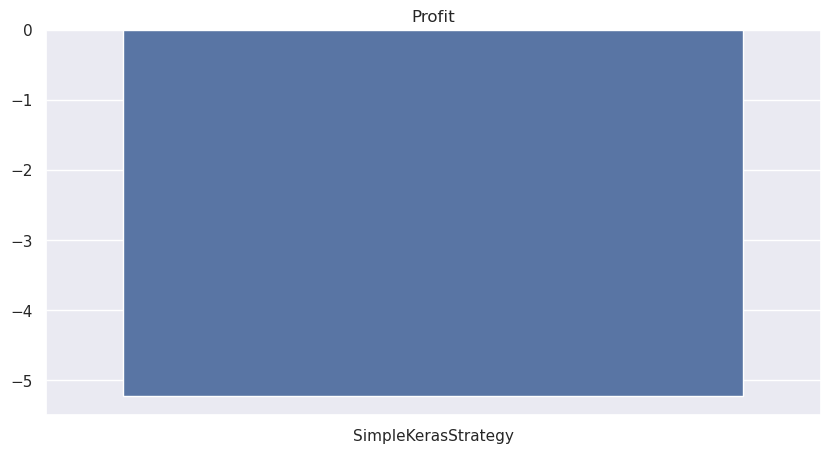

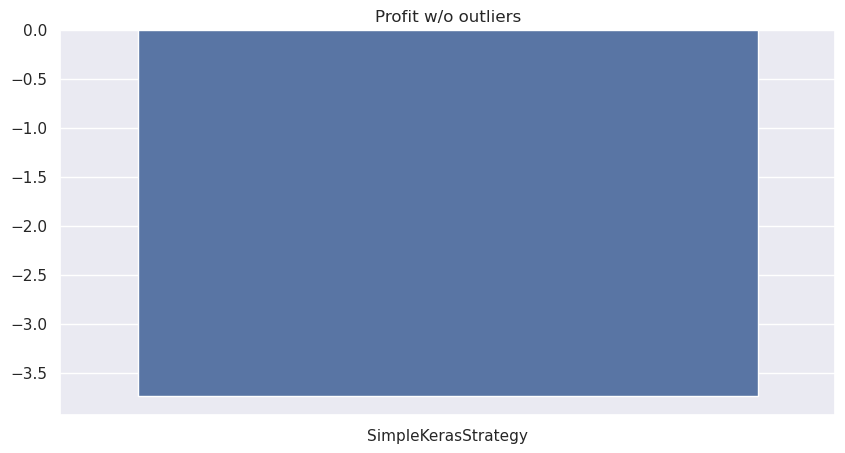

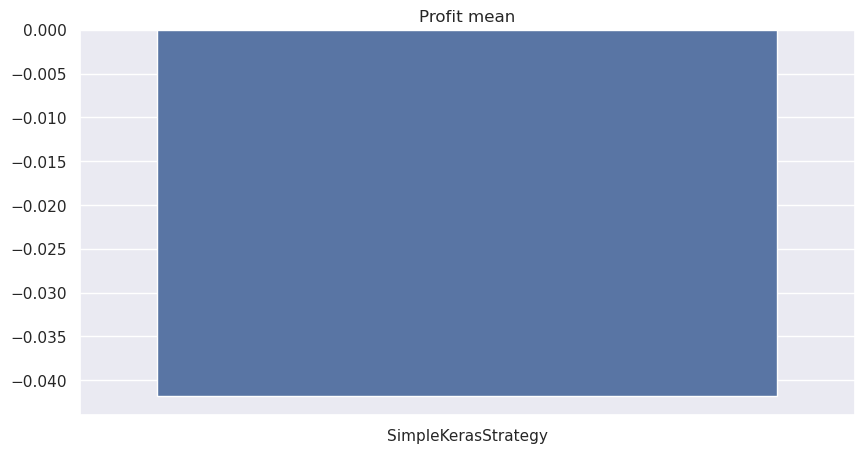

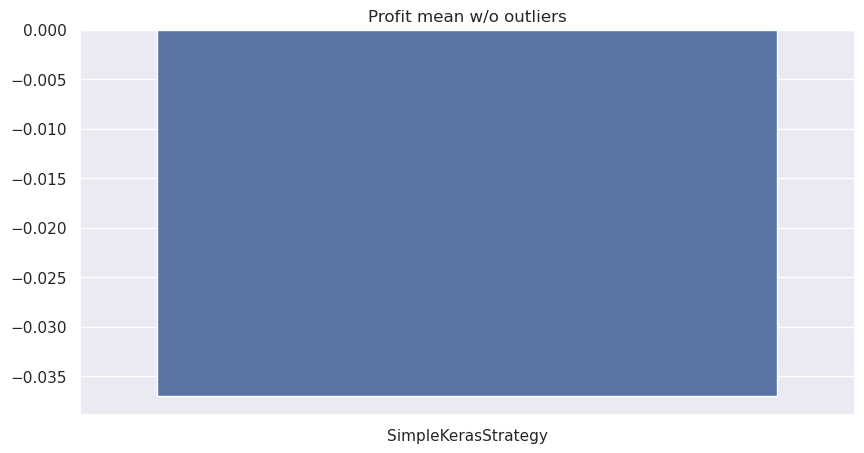

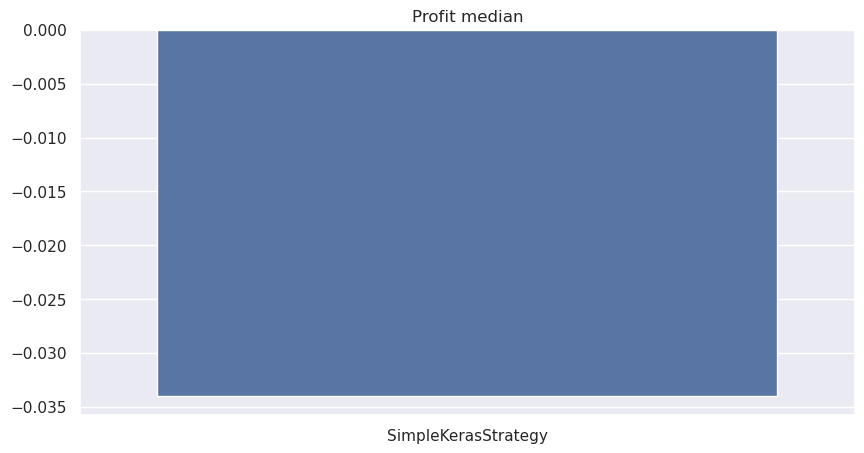

In [9]:
def plot_comparison(title, strategies_trades, y_func, quantiles=[0,1]):
    """ Comparison bar plot: x=strategy, y=summary function for the strategy"""
    data={"strategy":[], "profit":[]}
    #strategies_data = dict([(strategy,get_trades(strategy)) for strategy in strategies])
    for strategy in strategies:
        #val = get_trades(strategy)["profit"].sum()
        trades = strategies_trades[strategy]
        q_low = trades["profit"].quantile(quantiles[0])
        q_hi  = trades["profit"].quantile(quantiles[1])
        trades_filtered = trades[(trades["profit"] < q_hi) & (trades["profit"] > q_low)]      
        #trades_filtered=trades
        val = y_func(trades_filtered)
        data["strategy"].append(strategy)
        data["profit"].append(val)
    plt.figure(figsize=plot_figsize)
    sns.barplot(data=data, x="strategy", y="profit").set_title(title)
    plt.show()
    
q_outliers = [0.1, 0.9]
plot_comparison("Profit", strategies_trades, lambda trades: trades["profit"].sum())
plot_comparison("Profit w/o outliers", strategies_trades, lambda trades: trades["profit"].sum(), quantiles=q_outliers)
plot_comparison("Profit mean", strategies_trades, lambda trades: trades["profit"].mean())
plot_comparison("Profit mean w/o outliers", strategies_trades, lambda trades: trades["profit"].mean(), quantiles=q_outliers)
plot_comparison("Profit median", strategies_trades, lambda trades: trades["profit"].median())


### Buy, sell profit

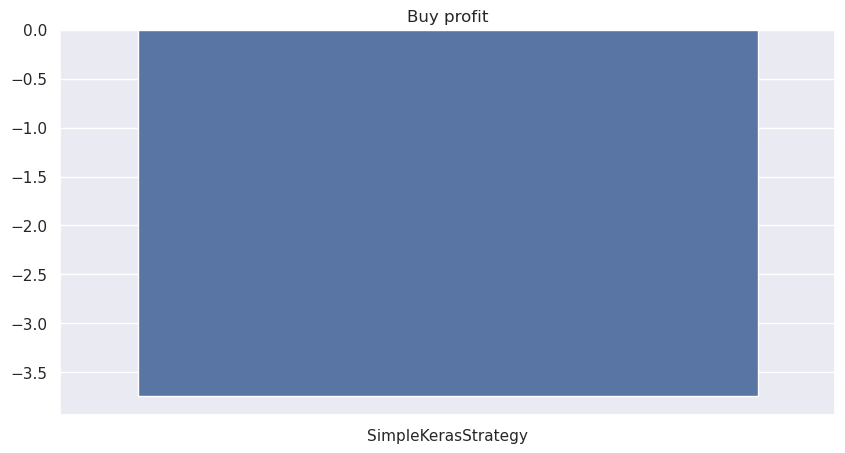

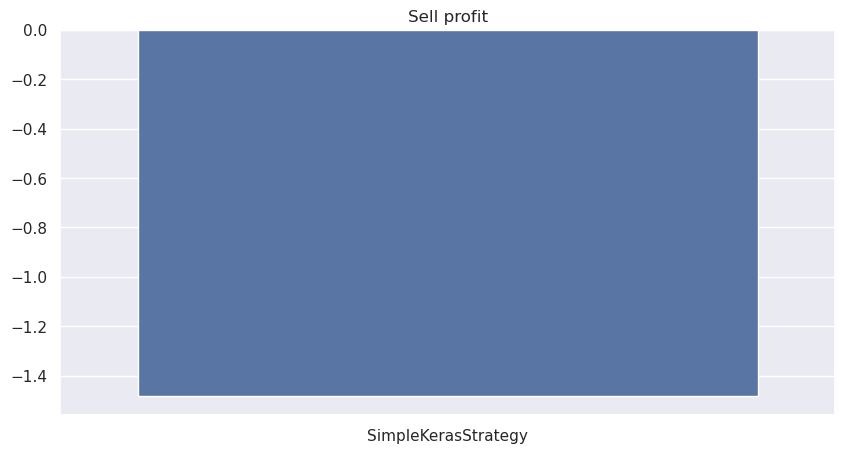

In [10]:
plot_comparison("Buy profit", strategies_trades, lambda trades: trades.loc[trades["side"]=="BUY","profit"].sum())
plot_comparison("Sell profit", strategies_trades, lambda trades: trades.loc[trades["side"]=="SELL","profit"].sum())


### Buy, sell mean profit

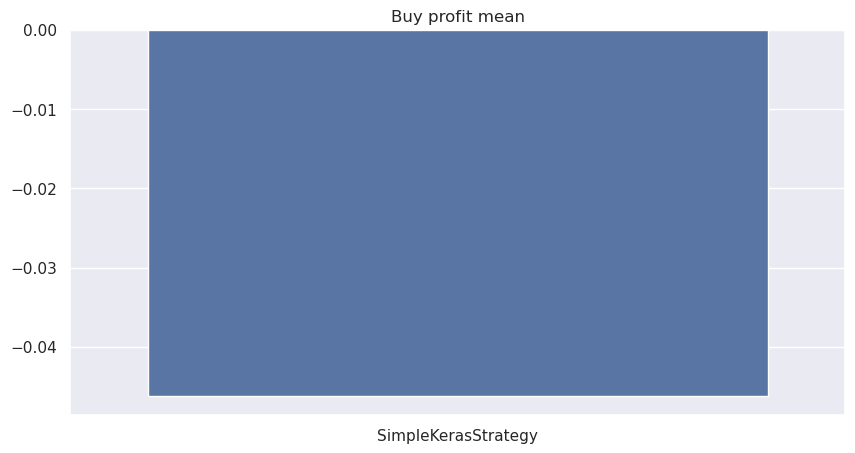

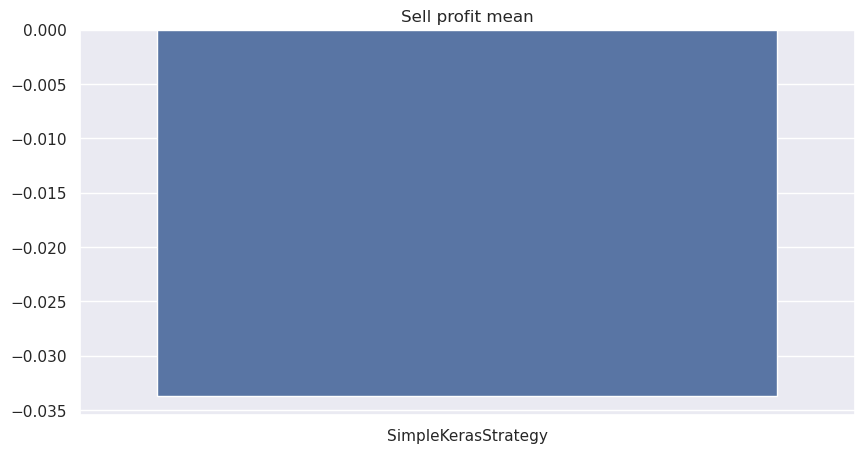

In [11]:
plot_comparison("Buy profit mean", strategies_trades, lambda trades: trades.loc[trades["side"]=="BUY","profit"].mean())
plot_comparison("Sell profit mean", strategies_trades, lambda trades: trades.loc[trades["side"]=="SELL","profit"].mean())


### Buy, sell median profit

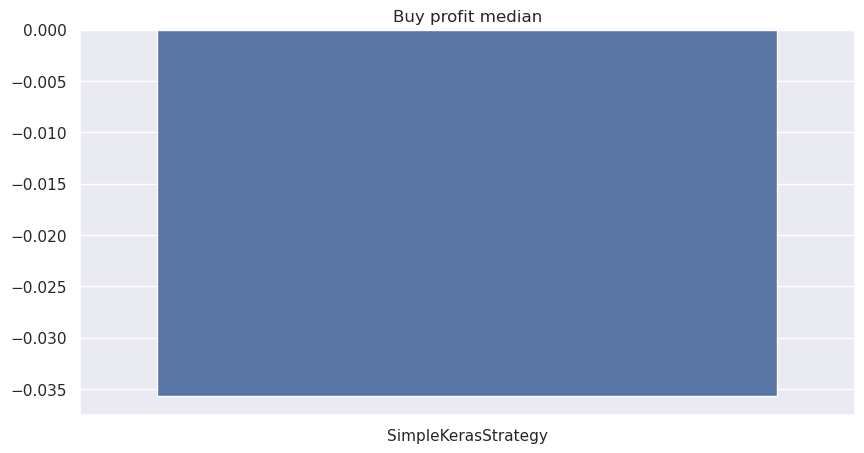

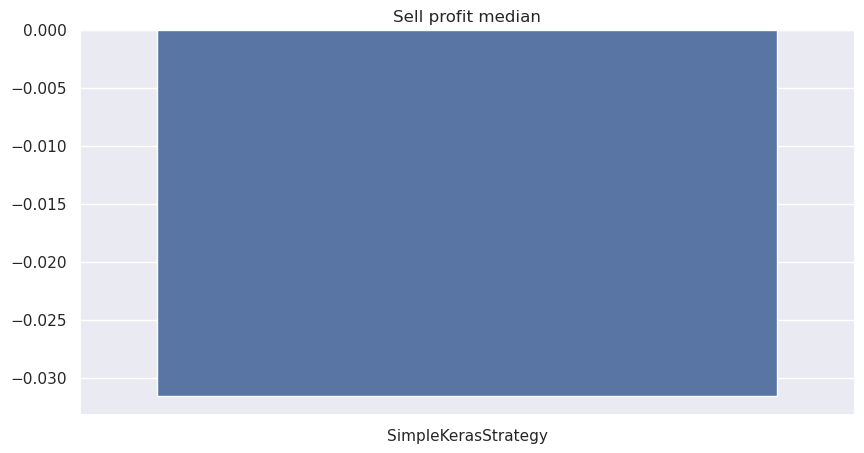

In [12]:
plot_comparison("Buy profit median", strategies_trades, lambda trades: trades.loc[trades["side"]=="BUY","profit"].median())
plot_comparison("Sell profit median", strategies_trades, lambda trades: trades.loc[trades["side"]=="SELL","profit"].median())


## Profit summary

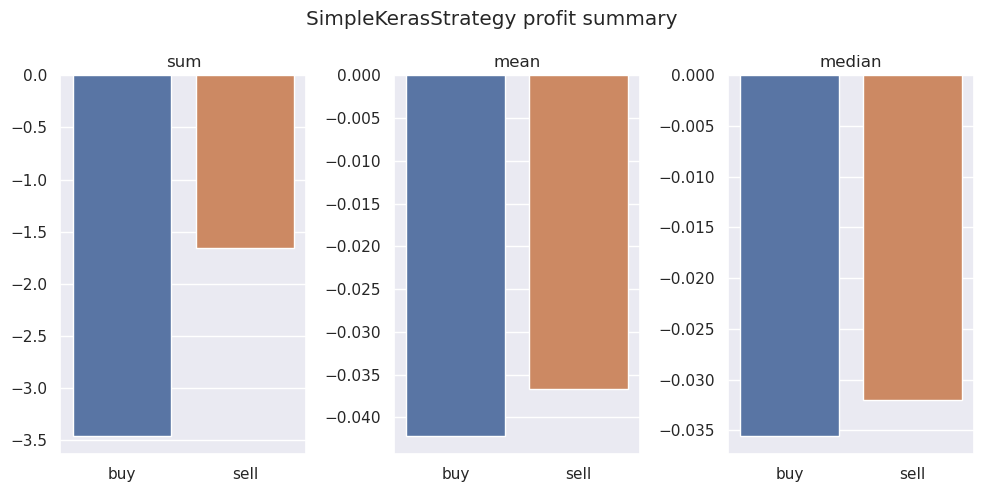

In [13]:
def plot_strategy_profit_sum(strategy, trades):
    """ Profit statistics: summary, average """
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(plot_figsize)
    fig.suptitle(f'{strategy} profit summary')
    
    buy_profit = trades.loc[trades["side"]=="BUY","profit"]
    sell_profit = trades.loc[trades["side"]=="SELL","profit"]

    # Plots
    sns.barplot(x=["buy", "sell"], y = [buy_profit.sum(), sell_profit.sum()], ax=ax1).set_title("sum")
    sns.barplot(x=["buy", "sell"], y = [buy_profit.mean(), sell_profit.mean()], ax=ax2).set_title("mean")
    sns.barplot(x=["buy", "sell"], y = [buy_profit.median(), sell_profit.median()], ax=ax3).set_title("median")
    fig.tight_layout()
    plt.show()

def plot_profit_sum(strategies_trades):
    """ Plot profit statistics for all strategies"""
    for strategy in strategies_trades:
        plot_strategy_profit_sum(strategy, strategies_trades[strategy])


        
plot_profit_sum(strategies_trades)        
